In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as np
import spacy
import glob
import os
from pathlib import Path

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st
import re

### textblob
from textblob import TextBlob

In [2]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### countvectorizer, tfidfvectorizer, embeddings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
import umap.umap_ as umap

import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModel, Trainer, TrainingArguments, pipeline
import umap

### gpu
#device = torch.device("npu:0") 
#tensor = torch.randn(3, 3).to(device) 
#print(tensor.device)
# 출력: npu:0

In [3]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### tqdm
from tqdm import tqdm

### gensim
import gensim
from gensim import models

### PCA
import random
from adjustText import adjust_text

### plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

In [4]:
# Load dataset
data_dir = Path(r"C:\Users\Hyemi\Python\TopicModeling\Data")
data_dir.mkdir(parents=True, exist_ok=True)
file_path = data_dir / "articles_tokenize.csv"
articles_full = pd.read_csv(file_path)

## 1. Embedding: group1

In [5]:
# Define a function to classify journals into groups
def classify_year_group(year):
    if 2013 <= year <= 2016:
        return "1"
    elif 2017 <= year <= 2019:
        return "2"
    elif 2020 <= year <= 2021:
        return "3"
    elif 2022 <= year <= 2024:
        return "4"
    else:
        return "5"

articles_full["Year_Group"] = articles_full["Year"].apply(classify_year_group)

# Load XLM-RoBERTa model and tokenizer
model_name = "xlm-roberta-large-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [6]:
def batch_get_embeddings(texts, model, tokenizer, batch_size=32):

    embeddings = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(batch_texts, padding=True, truncation=True, 
                           return_tensors="pt", max_length=512)
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Extract CLS token representations
        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(batch_embeddings)
    
    # Combine all batch embeddings
    return np.vstack(embeddings)

In [7]:
# Modify the column assignment
df = articles_full[articles_full["Year_Group"] == "1"]
df["Embeddings"] = list(batch_get_embeddings(
    df["Abstract"].tolist(), 
    model, 
    tokenizer
))

# Rest of the clustering code remains the same
embeddings_matrix = np.vstack(df["Embeddings"].values)
umap_model = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_model.fit_transform(embeddings_matrix)

# Optional: Add progress tracking
print("Embedding generation complete. Shape:", embeddings_matrix.shape)

Generating Embeddings: 100%|██████████████████████████████████████████████████████| 138/138 [8:15:01<00:00, 215.23s/it]


Embedding generation complete. Shape: (4395, 1024)


In [8]:
#import umap.umap_ as umap
#umap_model = umap.UMAP(n_components=2, random_state=42)
#embeddings_2d = umap_model.fit_transform(embeddings_matrix)

  File "C:\Users\Hyemi\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Hyemi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Hyemi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Hyemi\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


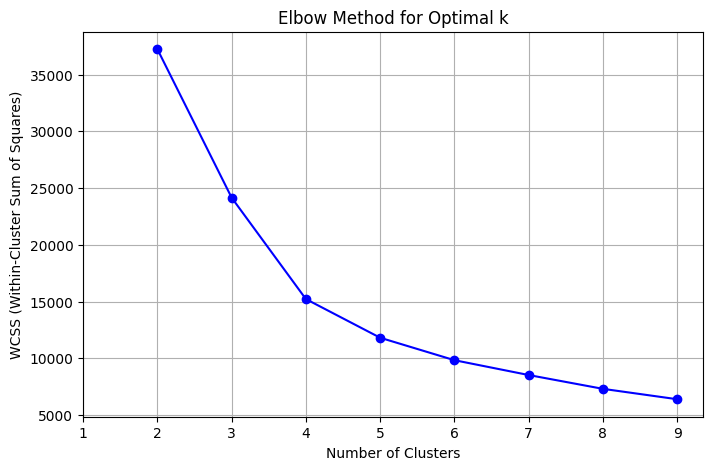

In [9]:
# Function to calculate the Within-Cluster Sum of Squares (WCSS) for different cluster sizes
def plot_elbow_method(embeddings_matrix, max_clusters=9):
    wcss = []  # List to store WCSS for each number of clusters
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings_matrix)
        wcss.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the closest centroid
    
    # Plot Elbow Graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), wcss, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal k")
    plt.xticks(range(1, max_clusters + 1))
    plt.grid()
    plt.show()
    
# Run the Elbow Method function to determine the optimal number of clusters
plot_elbow_method(embeddings_2d)

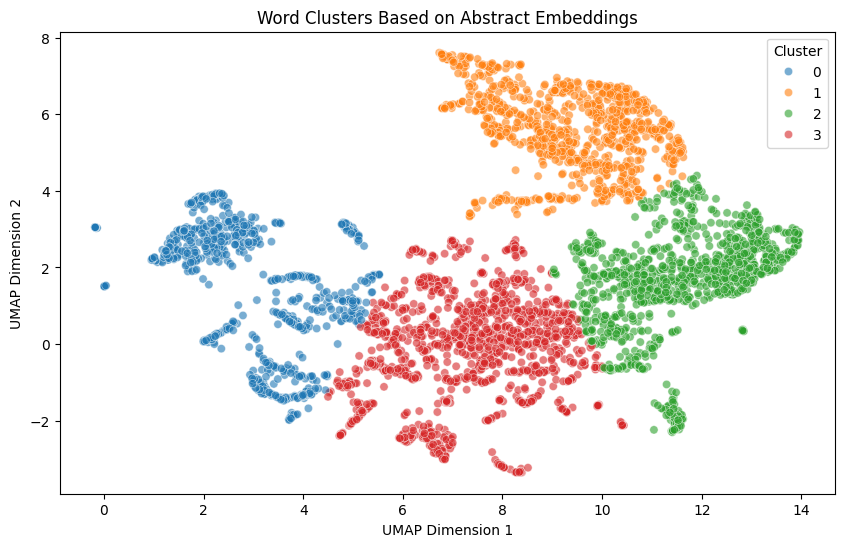

In [10]:
# Perform K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings_2d)

# Add clustering results to the dataframe
df["Cluster"] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=df["Cluster"], palette="tab10", alpha=0.6)
plt.title("Word Clusters Based on Abstract Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title="Cluster")
plt.show()

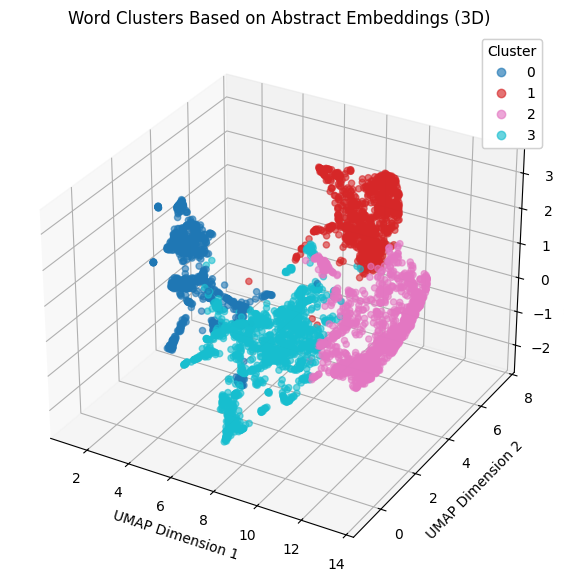

In [11]:
import umap.umap_ as umap

umap_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_3d.fit_transform(embeddings_matrix)

# Set number of clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings_3d)  # Use 3D embeddings

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], 
    c=df["Cluster"], cmap="tab10", alpha=0.6
)

# Labels and Title
ax.set_title("Word Clusters Based on Abstract Embeddings (3D)")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)

# Show plot
plt.show()

In [12]:
data_dir = Path(r"C:\Users\Hyemi\Python\TopicModeling\Data")
data_dir.mkdir(parents=True, exist_ok=True)

file_path = data_dir / "articles_embedding_1_full.csv"

df.to_csv(file_path, index=False)

In [13]:
df

,Year,Abstract,Abstract_tokens,Abstract_join,Year_Group,Embeddings,Cluster
687,2013,Graphs and tables differentially support perfo...,"['graph', 'table', 'differentially', 'support'...",graph table differentially support performance...,1,"[0.93702817, 1.051655, 0.94395494, -1.2717806,...",0
688,2013,“Agreement” is a grammatical relation between ...,"['agreement', 'grammatical', 'relation', 'word...",agreement grammatical relation word eg verbal ...,1,"[0.9954261, 1.3883544, 1.0582316, -1.623098, 0...",1
689,2013,Physiological evidence was sought for a center...,"['physiological', 'evidence', 'seek', 'centers...",physiological evidence seek centersurround att...,1,"[0.2881669, 1.467586, 1.3236185, -1.1915791, -...",0
690,2013,"Recent findings [Dilley and Pitt, . Psych. Sci...","['recent', 'dilley', 'pitt', 'psych', 'science...",recent dilley pitt psych science manipulate co...,1,"[1.400465, 1.1299914, 0.8205247, -1.5173582, 0...",0
691,2013,This study examines listener judgments of musi...,"['examine', 'listener', 'judgment', 'musical',...",examine listener judgment musical tension reco...,1,"[1.2932702, 1.5677495, 0.91826826, -1.7484328,...",2
...,...,...,...,...,...,...,...
5080,2016,Music is a potent mood regulator that can indu...,"['music', 'potent', 'mood', 'regulator', 'indu...",music potent mood regulator induce relaxation ...,1,"[1.4334998, 1.1907697, 0.7862094, -1.700899, 1...",3
5081,2016,Character processing is a crucial cognitive sk...,"['character', 'processing', 'crucial', 'cognit...",character processing crucial cognitive skill h...,1,"[1.0920974, 1.4165385, 0.8349855, -1.3049345, ...",3
5082,2016,This article extends previous research on the ...,"['article', 'extend', 'recovery', 'weak', 'fac...",article extend recovery weak factor loading co...,1,"[1.191828, 1.4534914, 1.0917306, -1.8351226, 0...",2
5083,2016,This paper investigates the role of acoustic a...,"['paper', 'investigate', 'role', 'acoustic', '...",paper investigate role acoustic categorical in...,1,"[1.2155958, 1.1829097, 0.96891636, -1.25046, 0...",1
